In [1]:
from numba.typed import Dict
from numba import types
from numba import njit, types
from numba.typed import Dict, List
import numpy as np

# @njit(fastmath=True)
def check_value_in_previous_pes(PEs: dict, pe_id: int, value: int, inc_current: bool = False) -> bool:
    """
    Check if a given value is present in the NumPy array for a specified processing element (PE).
    If inc_current is True, it also checks in the current PE.

    Args:
    PEs (dict): A dictionary where each key is a PE id and each value is a NumPy array of node indices.
    pe_id (int): The processing element id to check the value against.
    value (int): The value (node index) to check for.
    inc_current (bool): Whether to include the current PE's array in the check.

    Returns:bool: True if the value is found in the specified PE's array, False otherwise.
    """
    
    for id in range(0, pe_id + int(inc_current)):
        array = PEs[id]  # Directly access the array if the key exists
        if value in array:
            return True
    return False  # Return False if the key does not exist

In [2]:
import numpy as np

# Define a dictionary of processing elements (PEs) with NumPy arrays
PEs = {
    0: [10, 20, 30],
    1: [15, 25, 35],
    2: [12, 22, 32]
}

# Define the value to check
value_to_check = 22

# Define the processing element id to check against
pe_id_to_check = 2

# Check if the value is present in the specified PE's array (without including the current PE)
result_without_current = check_value_in_previous_pes(PEs, pe_id_to_check, value_to_check)
print(f"Is {value_to_check} present in PE {pe_id_to_check} (excluding current)? {result_without_current}")

# Check if the value is present in the specified PE's array (including the current PE)
result_with_current = check_value_in_previous_pes(PEs, pe_id_to_check, value_to_check, inc_current=True)
print(f"Is {value_to_check} present in PE {pe_id_to_check} (including current)? {result_with_current}")

Is 22 present in PE 2 (excluding current)? False
Is 22 present in PE 2 (including current)? True


In [3]:
import random

def generate_selection_exclusion(all_nodes, previous_nodes, k):
    
    # select nodes
    selected_values = []
    not_previous_nodes = []
    for x in all_nodes:
        if x not in previous_nodes:
            not_previous_nodes.append(x)    
    selected_values = random.sample(not_previous_nodes, min(k, len(not_previous_nodes)))
    if len(selected_values) < k:
        result = []
        for x in all_nodes:
            if x not in selected_values:
                result.append(x)
        print(result)
        random_values = random.sample(result, k - len(selected_values))
        for value in random_values:
            selected_values.append(value)
    
    return selected_values


# Example usage:
all_nodes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
previous_nodes = [1]
k = 9

selected_values = generate_selection_exclusion(all_nodes, previous_nodes, k)
print("Selected values:", selected_values)

Selected values: [8, 4, 7, 6, 2, 5, 9, 3, 0]


In [4]:
from numba import njit
import numpy as np
from numba.typed import Dict
from numba import types
from numba import njit, types
from numba.typed import Dict, List
import random


# @njit(fastmath=True)
def assign_values_to_pes_exclusion(num_nodes, node_updates_per_pe, number_pes, previous_nodes):
    
    all_nodes = np.arange(num_nodes)
    k = node_updates_per_pe * number_pes
    
    # select nodes
    selected_values = []
    not_previous_nodes = []
    for x in all_nodes:
        if x not in previous_nodes:
            not_previous_nodes.append(x)    
    selected_values = random.sample(not_previous_nodes, min(k, len(not_previous_nodes)))
    if len(selected_values) < k:
        result = []
        for x in all_nodes:
            if x not in selected_values:
                result.append(x)
        print(result)
        random_values = random.sample(result, k - len(selected_values))
        for value in random_values:
            selected_values.append(value)

    values_pool = np.array(selected_values)
    np.random.shuffle(values_pool)
    
    # Distribute values among PEs
    PEs = {}
    for i in range(number_pes):
        start_index = i * node_updates_per_pe
        end_index = min((i + 1) * node_updates_per_pe, num_nodes)
        pe_values = values_pool[start_index:end_index]
        PEs[i] = pe_values

    return PEs

num_nodes = 10
node_updates_per_pe = 1
number_pes = 1
previous_nodes = [0]
PEs = assign_values_to_pes_exclusion(num_nodes=num_nodes, 
                                     node_updates_per_pe=node_updates_per_pe, 
                                     number_pes=number_pes, 
                                     previous_nodes=previous_nodes)
print(PEs)

{0: array([6])}


In [5]:
from numba import njit
import numpy as np
from numba.typed import Dict
from numba import types
from numba import njit, types
from numba.typed import Dict, List

@njit(fastmath=True)
def assign_values_to_pes_exclusion(num_nodes, node_updates_per_pe, number_pes, previous_nodes):
    
    all_nodes = np.arange(num_nodes)
    k = node_updates_per_pe * number_pes
    
    not_previous_nodes = np.array([x for x in all_nodes if x not in previous_nodes])
    values_to_select = min(k, not_previous_nodes.shape[0])
    selected_values = np.random.choice(not_previous_nodes, values_to_select, replace=False)

    # print("selected values")
    # print(selected_values)
    # print("----------")

    # lst = []
    if selected_values.shape[0] < k:
        result = []
        for x in all_nodes:
            if x not in selected_values:
                result.append(x)
        
        result = np.array(result, dtype=np.int64)
        random_values = np.random.choice(result, k - selected_values.shape[0], replace=False)

        
        for value in random_values:
            # lst.append(value)
            selected_values = np.append(selected_values, value)
    # lst = np.array(lst, dtype=np.int64) if not len(lst) else np.empty(0, dtype=np.int64)
    # selected_values = np.concatenate((selected_values, lst))

    np.random.shuffle(selected_values)
    
    # Distribute values among PEs
    PEs = {}
    for i in range(number_pes):
        start_index = i * node_updates_per_pe
        end_index = min((i + 1) * node_updates_per_pe, num_nodes)
        pe_values = selected_values[start_index:end_index]
        PEs[i] = pe_values

    return PEs

num_nodes = 5
node_updates_per_pe = 5
number_pes = 1
previous_nodes = [4,1,2,3]
previous_nodes = np.array(previous_nodes, dtype=np.int64)
PEs = assign_values_to_pes_exclusion(num_nodes=num_nodes, 
                                     node_updates_per_pe=node_updates_per_pe, 
                                     number_pes=number_pes, 
                                     previous_nodes=previous_nodes)
print(PEs)

{0: [3 2 1 0 4]}


In [6]:
num_nodes = 5
node_updates_per_pe = 5
number_pes = 1
previous_nodes = [4,1,2,3]
previous_nodes = np.array(previous_nodes, dtype=np.int64)
PEs = assign_values_to_pes_exclusion(num_nodes=num_nodes, 
                                     node_updates_per_pe=node_updates_per_pe, 
                                     number_pes=number_pes, 
                                     previous_nodes=previous_nodes)
print(PEs)

{0: [2 0 1 3 4]}


### test

In [7]:
def assign_values_to_pes_exclusion_neighbours(num_nodes, node_updates_per_pe, number_pes, previous_nodes, previous_neighbours):
    
    all_nodes = np.arange(num_nodes)
    k = node_updates_per_pe * number_pes
    
    not_previous_nodes_neighbours = np.array([x for x in all_nodes if x not in previous_nodes and x not in previous_neighbours])

    print("not_previous_nodes_neighbours")
    print(not_previous_nodes_neighbours)

    # select value is not a node or not a neighbour
    values_to_select = min(k, not_previous_nodes_neighbours.shape[0])
    selected_values = np.random.choice(not_previous_nodes_neighbours, values_to_select, replace=False)

    if selected_values.shape[0] < k:

        # pad with neighbours (if we can't add everything using the set of no nodes and no neighbours)
        result = []
        for x in all_nodes:
            if x not in selected_values and x in previous_neighbours:
                result.append(x)
        result = np.array(result, dtype=np.int64)
        values_to_select = min(len(result), k - selected_values.shape[0])
        padding_neighbours = np.random.choice(result, values_to_select, replace=False)
        for value in padding_neighbours:
            selected_values = np.append(selected_values, value)

        if selected_values.shape[0] < k:
            # pad with nodes (if we can't add everything using the set of no nodes and no neighbours)
            result = []
            for x in all_nodes:
                if x not in selected_values and x in previous_nodes:
                    result.append(x)
            result = np.array(result, dtype=np.int64)
            values_to_select = min(len(result), k - selected_values.shape[0])
            padding_nodes = np.random.choice(result, min(len(result), k - selected_values.shape[0]), replace=False)
            for value in padding_nodes:
                selected_values = np.append(selected_values, value)

    np.random.shuffle(selected_values)

    # Distribute values among PEs
    PEs = {}
    for i in range(number_pes):
        start_index = i * node_updates_per_pe
        end_index = min((i + 1) * node_updates_per_pe, num_nodes)
        pe_values = selected_values[start_index:end_index]
        PEs[i] = pe_values

    return PEs


num_nodes = 10
node_updates_per_pe = 1
number_pes = 1
previous_nodes = [9]
previous_nodes = np.array(previous_nodes, dtype=np.int64)
previous_neighbours = [8]
previous_neighbours = np.array(previous_neighbours, dtype=np.int64)
PEs = assign_values_to_pes_exclusion_neighbours(num_nodes=num_nodes, 
                                     node_updates_per_pe=node_updates_per_pe, 
                                     number_pes=number_pes, 
                                     previous_nodes=previous_nodes,
                                     previous_neighbours=previous_neighbours)
print(PEs)

not_previous_nodes_neighbours
[0 1 2 3 4 5 6 7]
{0: array([3])}


In [8]:
PEs = assign_values_to_pes_exclusion_neighbours(num_nodes=num_nodes, 
                                     node_updates_per_pe=node_updates_per_pe, 
                                     number_pes=number_pes, 
                                     previous_nodes=previous_nodes,
                                     previous_neighbours=previous_neighbours)
print(PEs)

not_previous_nodes_neighbours
[0 1 2 3 4 5 6 7]
{0: array([6])}


# TESTING

In [9]:
def assign_values_to_pes_exclusion_neighbours(num_nodes, node_updates_per_pe, number_pes, previous_nodes, previous_neighbours):
    
    all_nodes = np.arange(num_nodes)
    k = node_updates_per_pe * number_pes
    
    not_previous_nodes_neighbours = np.array([x for x in all_nodes if x not in previous_nodes and x not in previous_neighbours])

    # print("not_previous_nodes_neighbours")
    # print(not_previous_nodes_neighbours)

    # select value is not a node or not a neighbour
    values_to_select = min(k, not_previous_nodes_neighbours.shape[0])
    selected_values = np.random.choice(not_previous_nodes_neighbours, values_to_select, replace=False)

    if selected_values.shape[0] < k:

        # pad with neighbours (if we can't add everything using the set of no nodes and no neighbours)
        result = []
        for x in all_nodes:
            if x not in selected_values and x in previous_neighbours:
                result.append(x)
        result = np.array(result, dtype=np.int64)
        values_to_select = min(len(result), k - selected_values.shape[0])
        padding_neighbours = np.random.choice(result, values_to_select, replace=False)
        for value in padding_neighbours:
            selected_values = np.append(selected_values, value)

        if selected_values.shape[0] < k:
            # pad with nodes (if we can't add everything using the set of no nodes and no neighbours)
            result = []
            for x in all_nodes:
                if x not in selected_values and x in previous_nodes:
                    result.append(x)
            result = np.array(result, dtype=np.int64)
            values_to_select = min(len(result), k - selected_values.shape[0])
            padding_nodes = np.random.choice(result, min(len(result), k - selected_values.shape[0]), replace=False)
            for value in padding_nodes:
                selected_values = np.append(selected_values, value)

    np.random.shuffle(selected_values)

    # Distribute values among PEs
    PEs = {}
    for i in range(number_pes):
        start_index = i * node_updates_per_pe
        end_index = min((i + 1) * node_updates_per_pe, num_nodes)
        pe_values = selected_values[start_index:end_index]
        PEs[i] = pe_values

    return PEs


num_nodes = 10
node_updates_per_pe = 1
number_pes = 1
previous_nodes = [0]
previous_nodes = np.array(previous_nodes, dtype=np.int64)
previous_neighbours = [1]
previous_neighbours = np.array(previous_neighbours, dtype=np.int64)
PEs = assign_values_to_pes_exclusion_neighbours(num_nodes=num_nodes, 
                                     node_updates_per_pe=node_updates_per_pe, 
                                     number_pes=number_pes, 
                                     previous_nodes=previous_nodes,
                                     previous_neighbours=previous_neighbours)
print(PEs)

{0: array([6])}


# Random Walk

In [10]:
def assign_values_to_pes_exclusion(num_nodes, node_updates_per_pe, number_pes, previous_nodes):
    
    all_nodes = np.arange(num_nodes)
    k = node_updates_per_pe * number_pes
    
    not_previous_nodes = np.array([x for x in all_nodes if x not in previous_nodes])
    values_to_select = min(k, not_previous_nodes.shape[0])
    selected_values = np.random.choice(not_previous_nodes, values_to_select, replace=False)

    # print("selected values")
    # print(selected_values)
    # print("----------")

    lst = []
    if selected_values.shape[0] < k:
        result = []
        for x in all_nodes:
            if x not in selected_values:
                result.append(x)
        
        result = np.array(result, dtype=np.int64)
        random_values = np.random.choice(result, k - selected_values.shape[0], replace=False)

        
        for value in random_values:
            lst.append(value)
            selected_values = np.append(selected_values, value)
    lst = np.array(lst, dtype=np.int64) if not len(lst) else np.empty(0, dtype=np.int64)
    selected_values = np.concatenate((selected_values, lst))

    np.random.shuffle(selected_values)
    
    # Distribute values among PEs
    PEs = {}
    for i in range(number_pes):
        start_index = i * node_updates_per_pe
        end_index = min((i + 1) * node_updates_per_pe, num_nodes)
        pe_values = selected_values[start_index:end_index]
        PEs[i] = pe_values

    return PEs

In [11]:
import numpy as np
from numba import njit
import numpy as np
from numba.typed import Dict
from numba import types
from numba import njit, types
from numba.typed import Dict, List

@njit(fastmath=True)
def assign_values_to_pes_random_walk(num_nodes, node_updates_per_pe, number_pes, previous_nodes, previous_neighbours):
    
    all_nodes = np.arange(num_nodes)
    k = node_updates_per_pe * number_pes
    
    if len(previous_neighbours) >= k:
        selected_values = np.random.choice(previous_neighbours, k, replace=False)
    else:
        selected_values = np.random.choice(previous_neighbours, k-len(previous_neighbours), replace=False)
    
    if selected_values.shape[0] < k:

        # filter not previous nodes
        result = []
        for x in all_nodes:
            if x not in previous_nodes and x not in selected_values:
                result.append(x)
        not_previous_nodes = np.array(result, dtype=np.int64)
        padding_nodes = np.random.choice(not_previous_nodes, min(len(not_previous_nodes), k - selected_values.shape[0]), replace=False)
        for value in padding_nodes:
            selected_values = np.append(selected_values, value)


    if selected_values.shape[0] < k:

        # filter for all nodes
        result = []
        for x in all_nodes:
            if x not in selected_values:
                result.append(x)
        filtered_previous_nodes = np.array(result, dtype=np.int64)
        padding_nodes = np.random.choice(filtered_previous_nodes, min(len(filtered_previous_nodes), k - selected_values.shape[0]), replace=False)
        for value in padding_nodes:
            selected_values = np.append(selected_values, value)


    np.random.shuffle(selected_values)

    # Distribute values among PEs
    PEs = {}
    for i in range(number_pes):
        start_index = i * node_updates_per_pe
        end_index = min((i + 1) * node_updates_per_pe, num_nodes)
        pe_values = selected_values[start_index:end_index]
        PEs[i] = pe_values

    return PEs

### exclusion

In [12]:
num_nodes = 10
node_updates_per_pe = 1
number_pes = 1
previous_nodes = [0]
previous_nodes = np.array(previous_nodes, dtype=np.int64)

PEs = assign_values_to_pes_exclusion(num_nodes=num_nodes, 
                                     node_updates_per_pe=node_updates_per_pe, 
                                     number_pes=number_pes, 
                                     previous_nodes=previous_nodes)

lst_exclusion = []
lst_exclusion.append(PEs[0][0])

In [13]:
for _ in range(1000):
    value_exclusion = PEs[0][0]
    PEs = assign_values_to_pes_exclusion(num_nodes=num_nodes, 
                                        node_updates_per_pe=node_updates_per_pe, 
                                        number_pes=number_pes, 
                                        previous_nodes=[value_exclusion])
    lst_exclusion.append(PEs[0][0])
    # print(PEs)

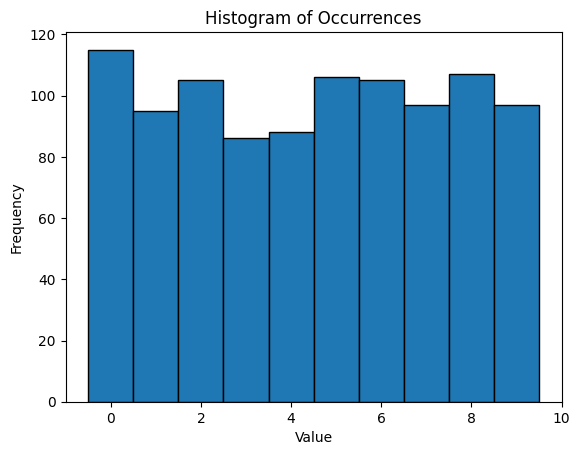

In [14]:
import matplotlib.pyplot as plt

# Example list of occurrences
occurrences = lst_exclusion

# Create histogram
plt.hist(occurrences, bins=range(min(occurrences), max(occurrences) + 2), edgecolor='black', align='left')

# Add title and labels
plt.title('Histogram of Occurrences')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()

### exclusion neighbours

In [15]:
num_nodes = 10
node_updates_per_pe = 1
number_pes = 1
previous_nodes = [0]
previous_nodes = np.array(previous_nodes, dtype=np.int64)
previous_neighbours = [1]
previous_neighbours = np.array(previous_neighbours, dtype=np.int64)
PEs = assign_values_to_pes_exclusion_neighbours(num_nodes=num_nodes, 
                                     node_updates_per_pe=node_updates_per_pe, 
                                     number_pes=number_pes, 
                                     previous_nodes=previous_nodes,
                                     previous_neighbours=previous_neighbours)
print(f"starting nodes = {previous_nodes}")
print(f"starting nodes' neighbours = {previous_neighbours}")
lst_exclusion_neighbours = []
lst_exclusion_neighbours.append(PEs[0][0])
print(f"lst = {lst_exclusion_neighbours}")
print("---------------------------")

starting nodes = [0]
starting nodes' neighbours = [1]
lst = [7]
---------------------------


In [16]:
for _ in range(1000):
    value_exclusion_neighbours = PEs[0][0]
    print(f"previous node selection = {[value_exclusion_neighbours]}")
    neigh_exclusion_neighbours = [value_exclusion_neighbours-1, value_exclusion_neighbours+1]
    if value_exclusion_neighbours == 0:
        del neigh_exclusion_neighbours[0]
    if value_exclusion_neighbours == num_nodes-1:
        del neigh_exclusion_neighbours[1]
    print(f"previous node selection's neighbours = {neigh_exclusion_neighbours}")

    PEs = assign_values_to_pes_exclusion_neighbours(num_nodes=num_nodes, 
                                        node_updates_per_pe=node_updates_per_pe, 
                                        number_pes=number_pes, 
                                        previous_nodes=[value_exclusion],
                                        previous_neighbours=neigh_exclusion_neighbours)
    print(f"PEs_value = {PEs[0][0]}")
    lst_exclusion_neighbours.append(PEs[0][0])
    print(f"lst = {lst_exclusion_neighbours}")
    print("---------------------------")

previous node selection = [7]
previous node selection's neighbours = [6, 8]
PEs_value = 5
lst = [7, 5]
---------------------------
previous node selection = [5]
previous node selection's neighbours = [4, 6]
PEs_value = 5
lst = [7, 5, 5]
---------------------------
previous node selection = [5]
previous node selection's neighbours = [4, 6]
PEs_value = 8
lst = [7, 5, 5, 8]
---------------------------
previous node selection = [8]
previous node selection's neighbours = [7, 9]
PEs_value = 1
lst = [7, 5, 5, 8, 1]
---------------------------
previous node selection = [1]
previous node selection's neighbours = [0, 2]
PEs_value = 6
lst = [7, 5, 5, 8, 1, 6]
---------------------------
previous node selection = [6]
previous node selection's neighbours = [5, 7]
PEs_value = 8
lst = [7, 5, 5, 8, 1, 6, 8]
---------------------------
previous node selection = [8]
previous node selection's neighbours = [7, 9]
PEs_value = 1
lst = [7, 5, 5, 8, 1, 6, 8, 1]
---------------------------
previous node select

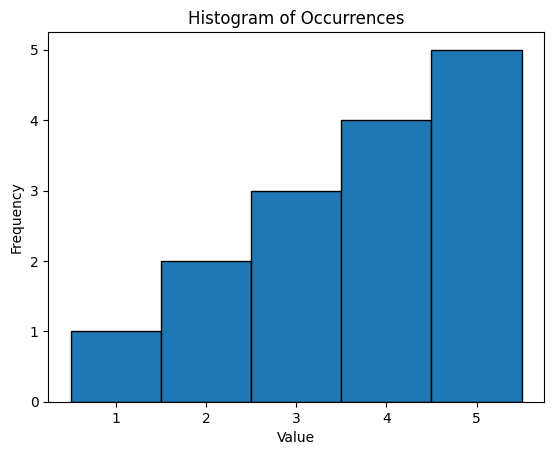

In [19]:
import matplotlib.pyplot as plt

# Example list of occurrences
occurrences = [1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5]

# Create histogram
plt.hist(occurrences, bins=range(min(occurrences), max(occurrences) + 2), edgecolor='black', align='left')

# Add title and labels
plt.title('Histogram of Occurrences')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()

### test

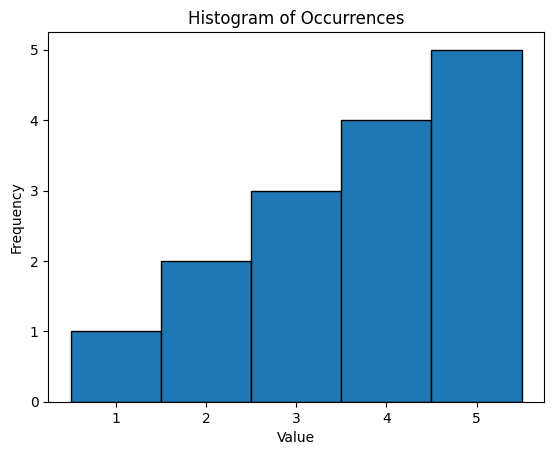

In [18]:
import matplotlib.pyplot as plt

# Example list of occurrences
occurrences = [1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5]

# Create histogram
plt.hist(occurrences, bins=range(min(occurrences), max(occurrences) + 2), edgecolor='black', align='left')

# Add title and labels
plt.title('Histogram of Occurrences')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()
